# Install CFO API package if not available

In [2]:
#pip install cfo

In [3]:
import os
import pandas as pd
import geopandas as gpd
import rioxarray as riox
from shapely.geometry import box

import json
import rasterio
from rasterio.mask import mask

import matplotlib.pyplot as plt

import cfo

#https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html

# About

This notebook uses the California Forest Observatory (CFO) API to download canopy height data for Santa Barbara County from the CFO data repository. See more about the API here:
https://github.com/forestobservatory/cfo-api

CFO's canopy height data is only available for the years 2016, 2018 and 2020. 

To use the notebook you will need to create CFO account. 

# Specify year and fp for canopy height data

In [5]:
# ************* NOTEBOOK VARIABLES ******************
# year shuold be 2016, 2018 or 2020
year = 2016

# file path where raster will be saved
fp = os.path.join(os.getcwd(),
                  'SantaBarbaraCounty_lidar',
                  'SantaBarbaraCounty_lidar'+str(year)+'.tif')

# Authenticate 

In [6]:
forest_api = cfo.api()
forest_api.authenticate()

CFO E-mail:  c_galazgarcia@ucsb.edu
CFO Password:  ············


200

# Download and open CA canopy height raster

In [ ]:
# find item id
ca_canopy_itemid = forest_api.search(geography='California', metric='CanopyHeight', year=year)[0]

# filepath to temporary folder
ca_canopy_fp = os.path.join(os.getcwd(), 
                            'temp',
                            'ca_canopyheight_'+str(year)+'.tif')

# download
forest_api.download(ca_canopy_itemid, ca_canopy_fp)

# open raster reader
ca_canopy = rasterio.open(ca_canopy_fp)

In [5]:
# year = 2016
# ca_canopy_fp = os.path.join(os.getcwd(), 'ca_canopyheight_'+str(year)+'.tif')
# ca_canopy_fp

'/home/jovyan/msai4earth-esa/iceplant_detection/model_with_lidar/ca_canopyheight_2016.tif'

In [ ]:
# ca_canopy = riox.open_rasterio(ca_canopy_fp, masked =True)
# ca_canopy

In [6]:
# ca_canopy = rasterio.open(ca_canopy_fp)

# Mask CA canopy height raster with Santa Barbara County bounding box

In [ ]:
# path to SB county shapefile
sb_fp = '/home/jovyan/msai4earth-esa/shapefiles_n_rasters/SB_geometry/SB_only.shp'
sb = gpd.read_file(sb_fp)
sb = sb.to_crs(ca_canopy.crs)

In [9]:
sb_mainland_bounds = sb.bounds.iloc[0]

bbox = box(sb_mainland_bounds.minx,
           sb_mainland_bounds.miny,
           sb_mainland_bounds.maxx,
           sb_mainland_bounds.maxy)
#bbox

minx    7.127352e+05
miny    3.809115e+06
maxx    8.270871e+05
maxy    3.889656e+06
Name: 0, dtype: float64

In [11]:
bbox_df = gpd.GeoDataFrame({'geometry':bbox}, index=[0], crs = sb.crs)
bbox_df

,geometry
0,"POLYGON ((827087.109 3809115.024, 827087.109 3..."


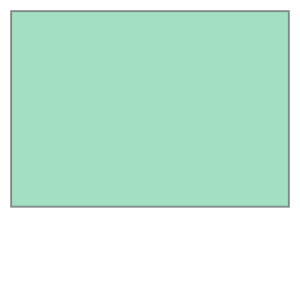

In [12]:
# sb_canopy = ca_canopy.rio.clip([sb_mainland.envelope], sb.crs)

AttributeError: 'DatasetReader' object has no attribute 'rio'

In [13]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]


In [14]:
coords = getFeatures(bbox_df)
coords

[{'type': 'Polygon',
  'coordinates': [[[827087.108958743, 3809115.024363572],
    [827087.108958743, 3889656.2901281836],
    [712735.1549834597, 3889656.2901281836],
    [712735.1549834597, 3809115.024363572],
    [827087.108958743, 3809115.024363572]]]}]

In [16]:
out_img, out_transform = mask(dataset=ca_canopy, shapes=coords, crop=True)

In [17]:
out_img

array([[[-9999, -9999, -9999, ...,     0,     0,     0],
        [-9999, -9999, -9999, ...,     0,     0,     0],
        [-9999, -9999, -9999, ...,     0,     0,     0],
        ...,
        [-9999, -9999, -9999, ...,     4,     3,     1],
        [-9999, -9999, -9999, ...,     3,     3,     1],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999]]], dtype=int16)

In [18]:
out_img = out_img.squeeze()
out_img.shape

(8055, 11436)

In [20]:
with rasterio.open(
        fp,  # file path
        'w',           # w = write
        driver='GTiff', # format
        height = out_img.shape[0], 
        width = out_img.shape[1],
        count = 1,  # number of raster bands in the dataset
        dtype = 'int16',
        crs = sb.crs,
        transform = out_transform,
) as dst:
    dst.write(out_img, 1)

In [22]:
clip = rasterio.open(fp).read([1]).squeeze()

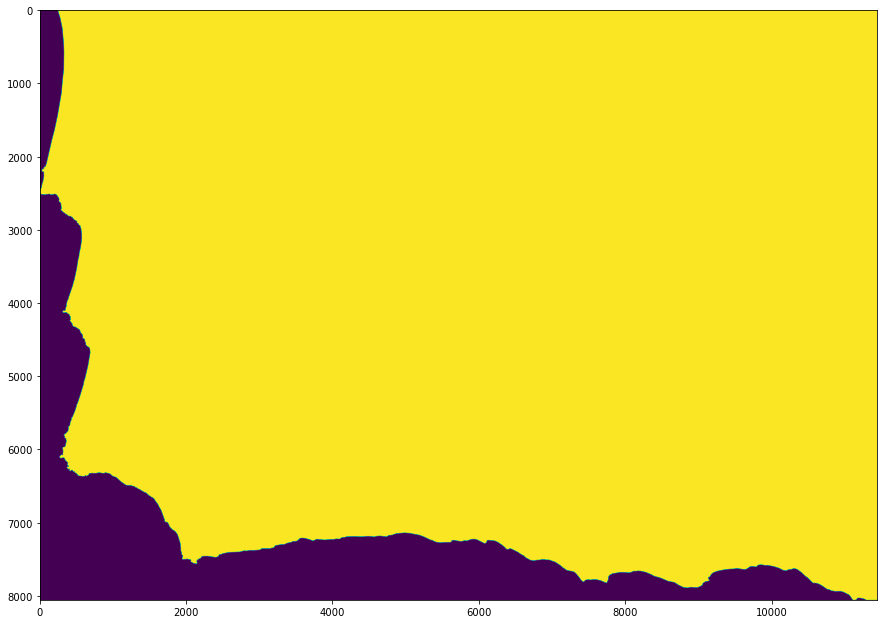

In [24]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(clip)
plt.show()

In [ ]:
os.reomve(ca_canopy_fp)

In [ ]:
#from osgeo import gdal